Let's see what a small random model has learned on a subset of two digits (1 and 3) from MNIST dataset. Firstly, load the model.

In [1]:
import torch

import capsule as cps
import trainer as trn

device = torch.device('cpu')

layers = []
decoders = []

model_folder = 'models/digits_1_and_3'

for index in range(1, 5):
    layer = cps.create_layer_from_state(state_dict=torch.load(f'{model_folder}/layer{index}'))
    decoder = trn.Decoder(state_dict=torch.load(f'{model_folder}/decoder{index}'))

    layer.to(device)
    decoder.to(device)

    layers.append(layer)
    decoders.append(decoder)

    print(f'Layer {index}:')
    print(f'    kernel size: {layer.kernel_size}')
    print(f'    stride: {layer.stride}')
    print(f'    number of capsule channels: {len(layer.vec_sizes)}')
    print(f'    number of features per capsule channel: {layer.vec_sizes}')
    print()


Layer 1:
    kernel size: 4
    stride: 1
    number of capsule channels: 4
    number of features per capsule channel: [4, 4, 4, 4]

Layer 2:
    kernel size: 3
    stride: 2
    number of capsule channels: 8
    number of features per capsule channel: [4, 4, 4, 4, 4, 4, 4, 4]

Layer 3:
    kernel size: 3
    stride: 2
    number of capsule channels: 8
    number of features per capsule channel: [6, 6, 6, 6, 6, 6, 6, 6]

Layer 4:
    kernel size: 4
    stride: 2
    number of capsule channels: 2
    number of features per capsule channel: [8, 8]



Create MnistData object and download MNIST dataset.

In [2]:
from mnist_data import MnistData

mnist_data = MnistData(root_folder='mnist_dataset')

mnist_data.download()


Let's display a few random examples of images decoded from the output of each layer.

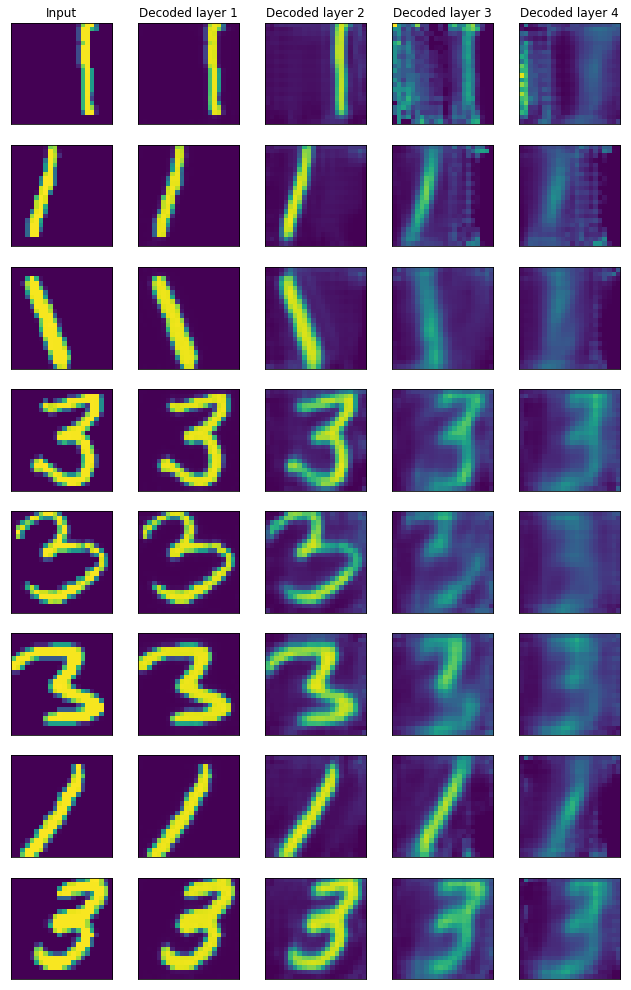

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

digits = [1, 3]
sample_grid_size = cps.input_grid_size_thru(layers, (1, 1))

num_samples = 8

loader = mnist_data.rand_cut_loader(sample_grid_size=sample_grid_size, batch_size=num_samples, train=False,
                                    digits=digits)

inputs = next(iter(loader))[0].to(device)

img_columns = [inputs]

with torch.no_grad():
    x = inputs

    for index, (layer, decoder) in enumerate(zip(layers, decoders)):
        x = layer(x)

        img_column = x
        for decoder in reversed(decoders[:index + 1]):
            img_column = decoder(img_column)
        img_columns.append(img_column)

img_scale = 2.2
plt.figure(figsize=(img_scale * len(img_columns), img_scale * num_samples))

subplot_index = 0
for sample_index in range(num_samples):
    for column_index, img_column in enumerate(img_columns):
        subplot_index += 1

        ax = plt.subplot(num_samples, len(img_columns), subplot_index)

        if sample_index == 0:
            ax.set_title('Input' if column_index == 0 else f'Decoded layer {column_index}')

        ax.set_yticks([])
        ax.set_xticks([])

        ax.imshow(img_column[sample_index].squeeze(dim=2).cpu(), vmin=0, vmax=1)

plt.show()


Let's see the histograms of the activations of the capsules in the last layer and calculate the accuracy. The activations are not distributed very well in the range [0, 1], especially the activations of the second capsule.

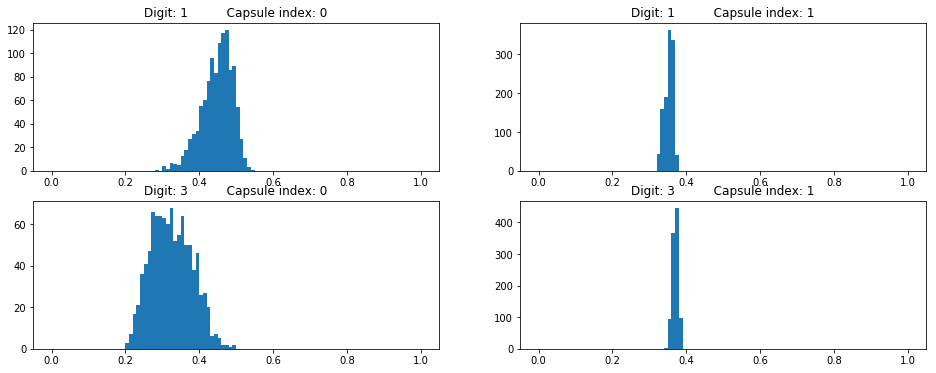

Accuracy: 87.6%


In [4]:
from torchvision import transforms

def get_last_layer_caps_activations(inputs, layers):
    with torch.no_grad():
        x = inputs
        for layer in layers:
            x = layer(x)

    x = x.squeeze()

    acts = []

    out_vec_index = 0
    for capsule_index, vec_size in enumerate(layers[-1].vec_sizes):
        out_vec_index += vec_size
        acts.append(x[None, :, out_vec_index])
        out_vec_index += 1

    return torch.cat(acts)


def get_digits_activations(digits, layers):
    digits_acts = []

    for digit in digits:
        transform = transforms.Compose([transforms.CenterCrop(sample_grid_size), transforms.ToTensor()])
        loader = mnist_data.data_loader(batch_size=-1, train=False, shuffle=False, transform=transform, digits=[digit])
        inputs = next(iter(loader))[0].squeeze(dim=1)[:, :, :, None].to(device)

        caps_acts = get_last_layer_caps_activations(inputs, layers)
        digits_acts.append(caps_acts)

    return digits_acts


def display_histograms(digits, activations):
    plt.figure(figsize=(16, 6))

    subplot_index = 0

    for digit, caps_acts in zip(digits, activations):
        for cap_index, cap_acts in enumerate(caps_acts):
            subplot_index += 1
            ax = plt.subplot(len(caps_acts), len(digits), subplot_index)
            ax.set_title(f'Digit: {digit}          Capsule index: {cap_index}')
            ax.hist(cap_acts, bins=100, range=(0, 1))

    plt.show()


def print_accuracy(activations):
    assert len(activations) == 2

    accuracy = 0

    for first_digit_acts, second_digit_acts in [(activations[0], activations[1]), (activations[1], activations[0])]:
        num_samples = len(first_digit_acts[0]) + len(second_digit_acts[0])

        num_predicted = (first_digit_acts[0] > first_digit_acts[1]).sum().item() + \
                        (second_digit_acts[0] < second_digit_acts[1]).sum().item()

        accuracy = max(accuracy, num_predicted / num_samples)

    print(f'Accuracy: {100 * accuracy:.1f}%')


activations = get_digits_activations(digits, layers)
display_histograms(digits, activations)
print_accuracy(activations)


If the activations are normalized, for each capsule separately, then the accuracy goes up from 87.6% to 90.8%. Let's normalize the activations and then see their histograms and the accuracy.

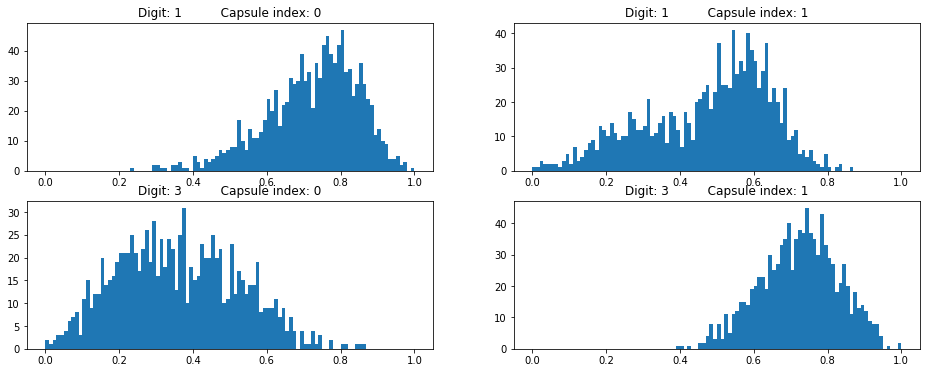

Accuracy: 90.8%


In [5]:
all_acts = torch.cat(activations, dim=1)
amin = all_acts.min(dim=1)[0][:, None]
amax = all_acts.max(dim=1)[0][:, None]

normalized = [(caps_acts - amin) / (amax - amin) for caps_acts in activations]

display_histograms(digits, normalized)
print_accuracy(normalized)
